# OR Suite 

Reinforcement learning (RL) is a natural model for problems involving real-time sequential decision making, including inventory control, resource allocation, ridesharing systems, and ambulance routing. In these models, an agent interacts with a system that has stochastic transitions and rewards, and aims to control the system by maximizing their cumulative rewards across the trajectory. Reinforcement learning has been shown in practice to be an effective technique for learning complex control policies.

# Ridesharing Code Demo

Reinforcement learning (RL) is a natural model for problems involving real-time sequential decision making. In these models, a principal interacts with a system having stochastic transitions and rewards and aims to control the system online (by exploring available actions using real-time feedback) or offline (by exploiting known properties of the system).

This project revolves around providing a unified landscape on scaling reinforcement learning algorithms to operations research domains.

In this notebook, we walk through the Ambulance Routing problem with a 1-dimensional reinforcement learning environment in the space $X = [0, 1]$. Each ambulance in the problem can be located anywhere in $X$, so the state space is $S = X^k$, where $k$ is the number of ambulances. For this example there will be only one ambulance, so $k = 1$.

The default distribution for call arrivals is $Beta(5, 2)$ over $[0,1]$, however any probability distribution defined over the interval $[0,1]$ is valid. The probability distribution can also change with each timestep.

For example, in a problem with two ambulances, imagine the ambulances are initially located at $0.4$ and $0.6$, and the distance function being used is the $\ell_1$ norm. The agent could choose to move the ambulances to $0.342$ and $0.887$. If a call arrived at $0.115$, ambulance 1, which was at $0.342$, would respond to that call, and the state at the end of the iteration would be ambulance 1 at $0.115$ and ambulance 2 at $0.887$. The agent could then choose new locations to move the ambulances to, and the cycle would repeat.

# Step 1: Package Installation
First we import the necessary packages

In [1]:
import or_suite
import numpy as np

import copy

import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
import pandas as pd


import gym

# Step 2: Pick problem parameters for the environment

Here we use the ambulance metric environment as outlined in `or_suite/envs/ambulance/ambulance_metric.py`.  The package has default specifications for all of the environments in the file `or_suite/envs/env_configs.py`, and so we use one the default for the ambulance problem in a metric space.

In addition, we need to specify the number of episodes for learning, and the number of iterations (in order to plot average results with confidence intervals).

In [2]:
CONFIG =  or_suite.envs.env_configs.rideshare_graph_default_config

epLen = CONFIG['epLen']
nEps = 100
numIters = 2

epsilon = (nEps * epLen)**(-1 / 4)
action_net = np.arange(start=0, stop=1, step=epsilon)
state_net = np.arange(start=0, stop=1, step=epsilon)

scaling_list = [0.1]

def beta(step):
    return np.random.beta(5,2)

# Step 3: Pick simulation parameters

Next we need to specify parameters for the simulation. This includes setting a seed, the frequency to record the metrics, directory path for saving the data files, a deBug mode which prints the trajectory, etc.

In [3]:
DEFAULT_SETTINGS = {'seed': 1, 
                    'recFreq': 1, 
                    'dirPath': '../data/rideshare/', 
                    'deBug': False, 
                    'nEps': nEps, 
                    'numIters': numIters, 
                    'saveTrajectory': True, 
                    'epLen' : 5,
                    'render': False,
                    'pickle': False
                    }

starting_state = CONFIG['starting_state']
num_cars = CONFIG['num_cars']

rideshare_env = gym.make('Rideshare-v0', config=CONFIG)
mon_env = Monitor(rideshare_env)

# Step 4: Pick list of algorithms

We have several heuristics implemented for each of the environments defined, in addition to a `Random` policy, and some `RL discretization based` algorithms. 

The `Stable` agent only moves ambulances when responding to an incoming call and not in between calls. This means the policy $\pi$ chosen by the agent for any given state $X$ will be $\pi_h(X) = X$

The `Median` agent takes a list of all past call arrivals sorted by arrival location, and partitions it into $k$ quantiles where $k$ is the number of ambulances. The algorithm then selects the middle data point in each quantile as the locations to station the ambulances.

In [4]:
agents = { # 'SB PPO': PPO(MlpPolicy, mon_env, gamma=1, verbose=0, n_steps=epLen),
'Random': or_suite.agents.rl.random.randomAgent(),
'max_weight_fixed' : or_suite.agents.rideshare.max_weight_fixed.maxWeightFixedAgent()
}

# Step 5: Run Simulations

Run the different heuristics in the environment

In [10]:
path_list_line = []
algo_list_line = []
path_list_radar = []
algo_list_radar= []
for agent in agents:
    print(agent)
    DEFAULT_SETTINGS['dirPath'] = '../data/rideshare'+str(agent)+'_'+str(num_cars)
    if agent == 'SB PPO':
        or_suite.utils.run_single_sb_algo(mon_env, agents[agent], DEFAULT_SETTINGS)
    elif agent == 'AdaQL' or agent == 'Unif QL' or agent == 'AdaMB' or agent == 'Unif MB':
        or_suite.utils.run_single_algo_tune(rideshare_env, agents[agent], scaling_list, DEFAULT_SETTINGS)
    else:
        or_suite.utils.run_single_algo(rideshare_env, agents[agent], DEFAULT_SETTINGS)

    path_list_line.append('../data/ambulance_metric_'+str(agent)+'_'+str(num_cars))
    algo_list_line.append(str(agent))
    path_list_radar.append('../data/ambulance_metric_'+str(agent)+'_'+str(num_cars))
    algo_list_radar.append(str(agent))

Random
**************************************************
Running experiment
**************************************************
**************************************************
Experiment complete
**************************************************
**************************************************
Saving data
**************************************************
Writing to file data.csv
**************************************************
Data save complete
**************************************************


# Step 6: Generate Figures

Create a chart to compare the different heuristic functions

In [6]:
fig_path = '../figures/'
fig_name = 'ambulance_metric'+'_'+str(num_ambulance)+'_'+str(alpha)+'_'+str(arrival_dist.__name__)+'_line_plot'+'.pdf'
or_suite.plots.plot_line_plots(path_list_line, algo_list_line, fig_path, fig_name, int(nEps / 40)+1)

additional_metric = {'MRT': lambda traj : or_suite.utils.mean_response_time(traj, lambda x, y : np.abs(x-y)), 'RTV': lambda traj : or_suite.utils.response_time_variance(traj, lambda x, y : np.abs(x-y))}
fig_name = 'ambulance_metric'+'_'+str(num_ambulance)+'_'+str(alpha)+'_'+str(arrival_dist.__name__)+'_radar_plot'+'.pdf'
or_suite.plots.plot_radar_plots(path_list_radar, algo_list_radar,
fig_path, fig_name,
additional_metric
)

# TODO: Import figures and display


  Algorithm    Reward      Time   Space       MRT       RTV
0    Random -1.420085  7.052635 -4726.0 -0.335064 -0.050939
1    Stable -1.001835  7.732670 -3804.0 -0.291050 -0.065029
2    Median -0.658575  6.494975 -4544.5 -0.135620 -0.011065


# Visualization Demo

The following demo includes a command-line interface with a visualization to demonstrate how the Ambulance Routing code works with 2 ambulances.

The following commands need to be used in the terminal to install the necessary packages:
* `apt-get install -y xvfb python-opengl`
* `pip install gym pyvirtualdisplay`
* `pip install scikit-learn-extra`
* `pip install stable_baselines3`
* `pip install pyglet==1.5.16`

The first two are needed for the simulation but the rest should already be installed from the code demo above.

## Simulation

Run the cell below to run the simulation. In this simulation, you are trying to minimize the distance traveled by two ambulances to respond to incoming calls. The parameters in the problem are set up so the distance traveled to respond to a call is three times as costly as the distance traveled between calls. The reward is the negative cost, because reward is something that you want to maximize. Your goal therefore is to keep the reward as close to zero as possible.

These are some questions you could ask yourself when choosing actions:

* Should I focus more on minimizing distance traveled between calls, or distance traveled to respond to a call?

* Do calls seem to arrive more in a certain part of the range $0$ to $1$? Can I take advantage of that?

* Am I able to improve your performance over multiple rounds? (once you've finished you can re-run the cell to try again!)

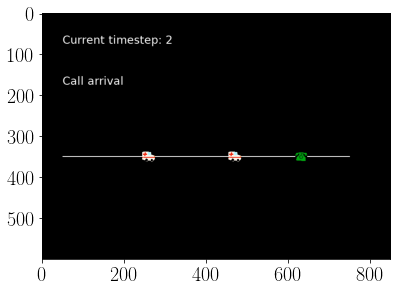

/home/sean/anaconda3/envs/ORSuite/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


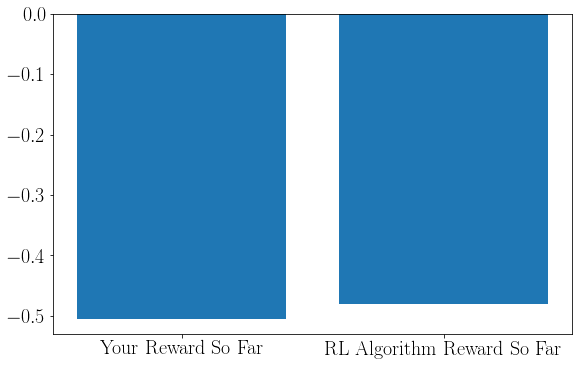


The most recent call arrival was at 0.8320872, and ambulance 2 responded to the call.



KeyboardInterrupt: Interrupted by user

In [7]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(500, 800))
display.start()

import or_suite
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import time
import copy

a = 5
b = 2
CONFIG = {'epLen': 5,
    'arrival_dist': lambda x : np.random.beta(a,b), 
    'alpha': 0.25, 
    'starting_state': np.array([0.0, 0.0]), 
    'num_ambulance': 2,
    'norm': 1
}

alpha = CONFIG['alpha']
epLen = CONFIG['epLen']
state = CONFIG['starting_state']
num_ambulance = CONFIG['num_ambulance']

agent = or_suite.agents.ambulance.command_line_metric.commandLineAgent(epLen)
env = gym.make('Ambulance-v0', config=CONFIG)
env.reset()


done = False
your_rewards = []
heuristic_agent_rewards = []
your_total_reward = 0
heuristic_agent_total_reward = 0

median_est = (a - 1/3)/(a + b - 2/3)
heuristic_agent_states = [state]

x_axis = ['Your Reward So Far', 'RL Algorithm Reward So Far']


def display_animation(screen, time_to_display):
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    if time_to_display is not None:
        ipythondisplay.display(plt.gcf())
        time.sleep(time_to_display)

def plot_rewards():
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    y_axis = [your_total_reward, heuristic_agent_total_reward]
    ax.bar(x_axis, y_axis)
    plt.show()


while not done:
    action = agent.greedy(state, 0)
    state, reward, done, info = env.step(action)
    your_rewards.append(reward)
    your_total_reward += reward

    # by comparing the final state with the action the user chose, we can figure out where the most recent arrival was
    previous_arrival_ind = np.argmax(np.abs(action - state))
    previous_arrival = state[previous_arrival_ind]

    # the heuristic agent always chooses to put all the ambulances at the median estimate
    heuristic_agent_action = np.full(num_ambulance, median_est)

    # the state will have one ambulance where the call arrived, and all other ambulances at the median estimate
    # doesn't matter which ambulance responds to the call because they're all at the same place
    heuristic_agent_state = np.concatenate([np.full(num_ambulance - 1, median_est), [previous_arrival]])
    heuristic_agent_states.append(heuristic_agent_state)

    heuristic_agent_reward = -1 * (alpha * np.sum(np.abs(heuristic_agent_states[-2] - heuristic_agent_action)) + (1 - alpha) * np.sum(np.abs(heuristic_agent_action - heuristic_agent_state)))
    heuristic_agent_rewards.append(heuristic_agent_reward)
    heuristic_agent_total_reward += heuristic_agent_reward

    screen1, screen2, screen3 = env.render(mode='rgb_array')

    # display each step of the environment for 2 seconds
    display_animation(screen1, 2)
    display_animation(screen2, 2)
    display_animation(screen3, None)

    # plot your reward vs the agent's reward
    plot_rewards()
    time.sleep(2)

    print("\nThe most recent call arrival was at " + str(previous_arrival) + ", and ambulance " + str(previous_arrival_ind+1) + " responded to the call.\n")

    time.sleep(2)


ipythondisplay.clear_output(wait=True)
env.close()

if np.sum(your_rewards) >= np.sum(heuristic_agent_rewards):
    print("CONGRATS! You beat the RL algorithm.")
else:
    print("You did not get a better reward than the RL algorithm.")

print("\nYour total reward over all iterations was ", round(sum(your_rewards),3))
print("The RL algorithm's total reward over all iterations was ", round(sum(heuristic_agent_rewards),3), "\n")

plot_rewards()